## <u>*Regression Modelling for claims cost as a Target Feature*</u>

In [65]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
import os
import json


from sklearn.metrics import (
    root_mean_squared_error,r2_score
)

from sklearn.ensemble import (
    RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor
)

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBRFRegressor

from sklearn.linear_model import (
    LinearRegression,GammaRegressor,ElasticNet
)

from sklearn.model_selection import (
    train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
)

from sklearn.preprocessing import (
        LabelEncoder,StandardScaler,PowerTransformer,StandardScaler,OneHotEncoder,OrdinalEncoder
        )

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from tqdm import tqdm

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

from hyperopt import (
    fmin, tpe, hp, SparkTrials, STATUS_OK,Trials
)

In [66]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")
df=df.drop(["X_OBSTAT_","clm","numclaims"],axis=1)
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")
df=df[df["veh_value"] != 0]
df["veh_value"]=df["veh_value"]*10000
df=df[df["claimcst0"] != 0]
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
14,16600.0,0.484600,669.509999,SEDAN,3,M,B,6
16,15100.0,0.993840,806.609999,SEDAN,3,F,F,4
17,7600.0,0.539357,401.805451,HBACK,3,M,C,4
40,18900.0,0.654346,1811.709997,STNWG,3,M,F,2
64,40600.0,0.851472,5434.439987,STNWG,2,M,F,3


In [67]:
df.shape

(4618, 8)

In [68]:
import numpy as np
import scipy.stats as stats
threshold = np.percentile(df["claimcst0"], 95)
excesses = df["claimcst0"][df["claimcst0"] > threshold] - threshold
shape, loc, scale = stats.genpareto.fit(excesses)
extreme_values = stats.genpareto.ppf(0.99, shape, loc=loc, scale=scale) + threshold
claimcst0_outliers = df["claimcst0"][df["claimcst0"] > extreme_values]
df=df[df["claimcst0"].isin(list(claimcst0_outliers.values)) == False]

---

In [69]:
df=df.sort_values(by=['veh_age', 'agecat','area','gender']).reset_index().drop("index",axis=1)
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,25600.0,0.810404,11653.230000,HDTOP,1,F,A,1
1,13990.0,0.862423,1259.189999,HBACK,1,F,A,1
2,31300.0,0.407940,850.830000,STNWG,1,F,A,1
3,13990.0,0.358658,367.730000,HBACK,1,F,A,1
4,14700.0,0.353183,200.000000,HBACK,1,F,A,1


---

*Define categorical features and numerical features :*

In [70]:
categorical_features=df.select_dtypes(include=["object"])
numerical_features=df.select_dtypes(exclude=["object"])

print("we have {} numerical features : {}\n".format(numerical_features.shape[1],list(numerical_features.columns)))
print("we have {} categorical features : {}".format(categorical_features.shape[1],list(categorical_features.columns)))

we have 3 numerical features : ['veh_value', 'exposure', 'claimcst0']

we have 5 categorical features : ['veh_body', 'veh_age', 'gender', 'area', 'agecat']


*Categorical features Frequency percenatge :*

In [71]:
for col in categorical_features:
    print(df[col].value_counts(normalize=True)*100)

veh_body
SEDAN    31.982665
HBACK    27.367281
STNWG    25.308776
UTE       5.633803
HDTOP     2.816901
TRUCK     2.578548
COUPE     1.473456
PANVN     1.343445
MIBUS     0.931744
MCARA     0.303359
BUS       0.151679
CONVT     0.065005
RDSTR     0.043337
Name: proportion, dtype: float64
veh_age
3    29.512459
2    27.258938
4    25.417118
1    17.811484
Name: proportion, dtype: float64
gender
F    57.334778
M    42.665222
Name: proportion, dtype: float64
area
C    30.595883
A    23.423619
B    20.866739
D    10.725894
E     8.342362
F     6.045504
Name: proportion, dtype: float64
agecat
3    24.073673
4    23.900325
2    20.151679
5    13.282774
1    10.704225
6     7.887324
Name: proportion, dtype: float64


*Visualizing numerical features :*

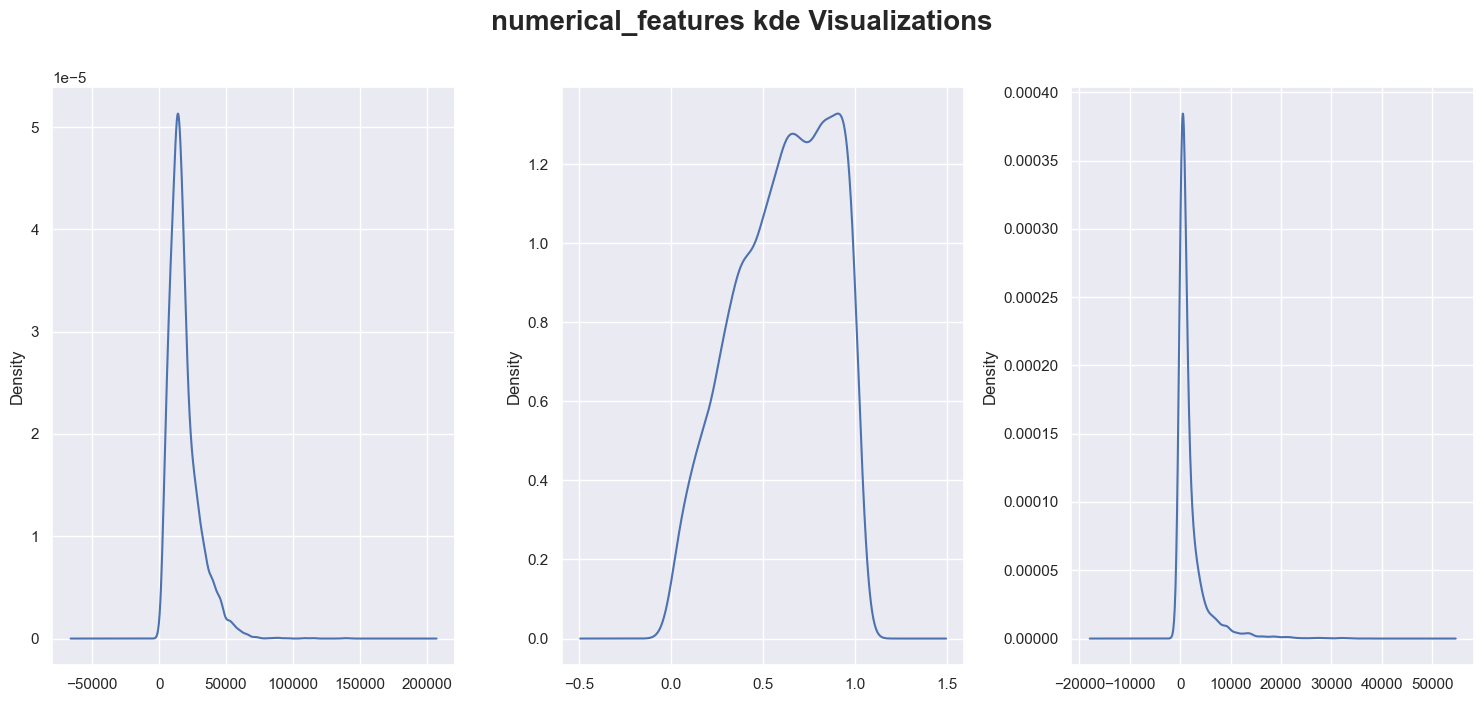

In [72]:
def plot_numerical_features(numerical_features,ChartType):
    nrows = 1
    ncols = 3

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,7))
    fig.suptitle(f"numerical_features {ChartType} Visualizations",fontsize=20,fontweight="bold",y=1.)
    
    axes = axes.flatten()

    for i, column in enumerate(numerical_features.columns):
        if i >= nrows * ncols:
            break 
        numerical_features[column].plot(ax=axes[i], kind=f"{ChartType}")
        plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/generalGraphs/plot_numerical_features_with_claims.png',dpi=500);
        


    plt.tight_layout()
    plt.show()

plot_numerical_features(numerical_features[["veh_value","exposure","claimcst0"]],"kde")


*Visualizing categorical features :*

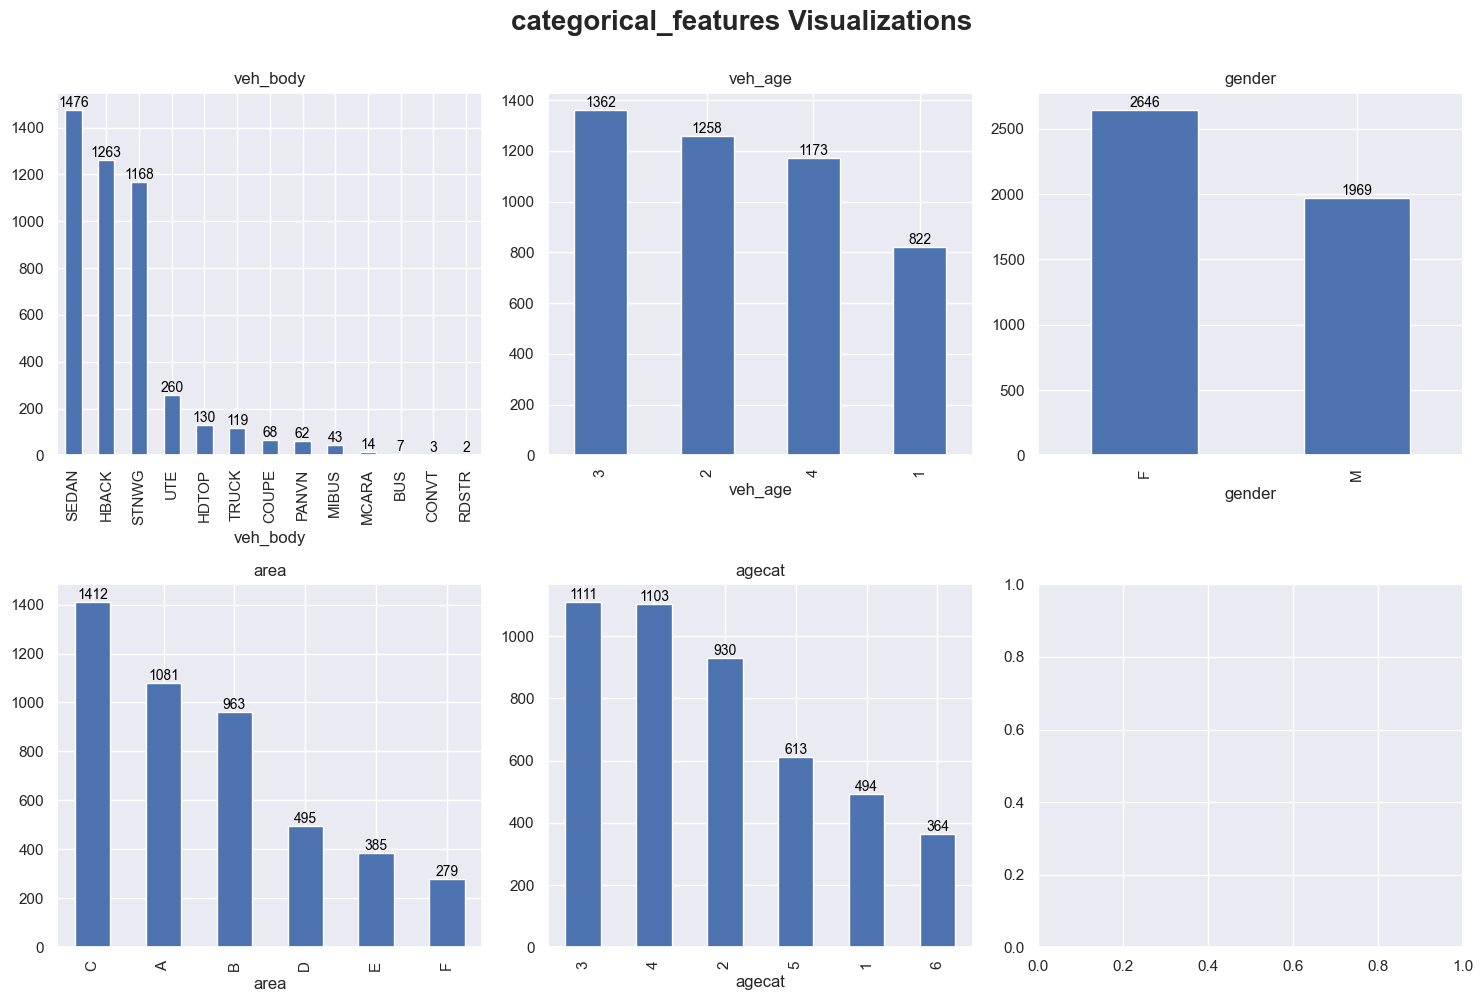

In [73]:
def plot_categorical_features(categorical_features):
    nrows = 2
    ncols = 3
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    fig.suptitle(f"categorical_features Visualizations",fontsize=20,fontweight="bold",y=1.)

    axes = axes.flatten()
    
    for i, column in enumerate(categorical_features.columns):
        if i >= nrows * ncols:
            break 
        ax = axes[i]
        counts = categorical_features[column].value_counts()
        counts.plot(kind='bar', ax=ax, title=column)
        
        for bar in ax.patches:
            ax.annotate(
                str(bar.get_height()),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points'
            )
        plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/generalGraphs/plot_categorical_features_with_claims.png',dpi=500);
        
    plt.tight_layout()
    plt.show()

plot_categorical_features(categorical_features)    

---

*Define discretes feature and countinuous features :*

In [74]:
discrete_feature=[feature for feature in numerical_features if  len(df[feature].unique())<=25]
countinuous_feature=[feature for feature in numerical_features if  len(df[feature].unique())>25]

In [75]:

print("we have {} discrete feature : {}\n".format(len(discrete_feature),(discrete_feature)))
print("we have {} countinuous feature : {}".format(len(countinuous_feature),(countinuous_feature)))

we have 0 discrete feature : []

we have 3 countinuous feature : ['veh_value', 'exposure', 'claimcst0']


---

*Categorical features by average claimcst0 :*

In [76]:
df.groupby("gender")["claimcst0"].mean().to_frame().T

gender,F,M
claimcst0,1836.756662,2176.885854


In [77]:
df.groupby("agecat")["claimcst0"].mean().to_frame().T

agecat,1,2,3,4,5,6
claimcst0,2549.537992,2072.606764,1916.16166,1902.091035,1711.926091,1876.586824


In [78]:
df.groupby("veh_age")["claimcst0"].mean().to_frame().T

veh_age,1,2,3,4
claimcst0,1762.881531,1931.871966,1995.768723,2172.826786


In [79]:
df.groupby("veh_body")["claimcst0"].mean().to_frame().T

veh_body,BUS,CONVT,COUPE,HBACK,HDTOP,MCARA,MIBUS,PANVN,RDSTR,SEDAN,STNWG,TRUCK,UTE
claimcst0,1691.322855,2296.269999,2760.636039,2012.541237,2267.783604,762.425,2700.113481,2146.990524,684.729089,1816.817397,1931.211559,2583.994609,2296.957557


In [80]:
df.groupby("area")["claimcst0"].mean().to_frame().T

area,A,B,C,D,E,F
claimcst0,1807.420012,1861.752738,2029.537683,1839.456612,2255.407845,2706.40574


---

*Visualizing Categorical and numerical features by claimcst0 :*

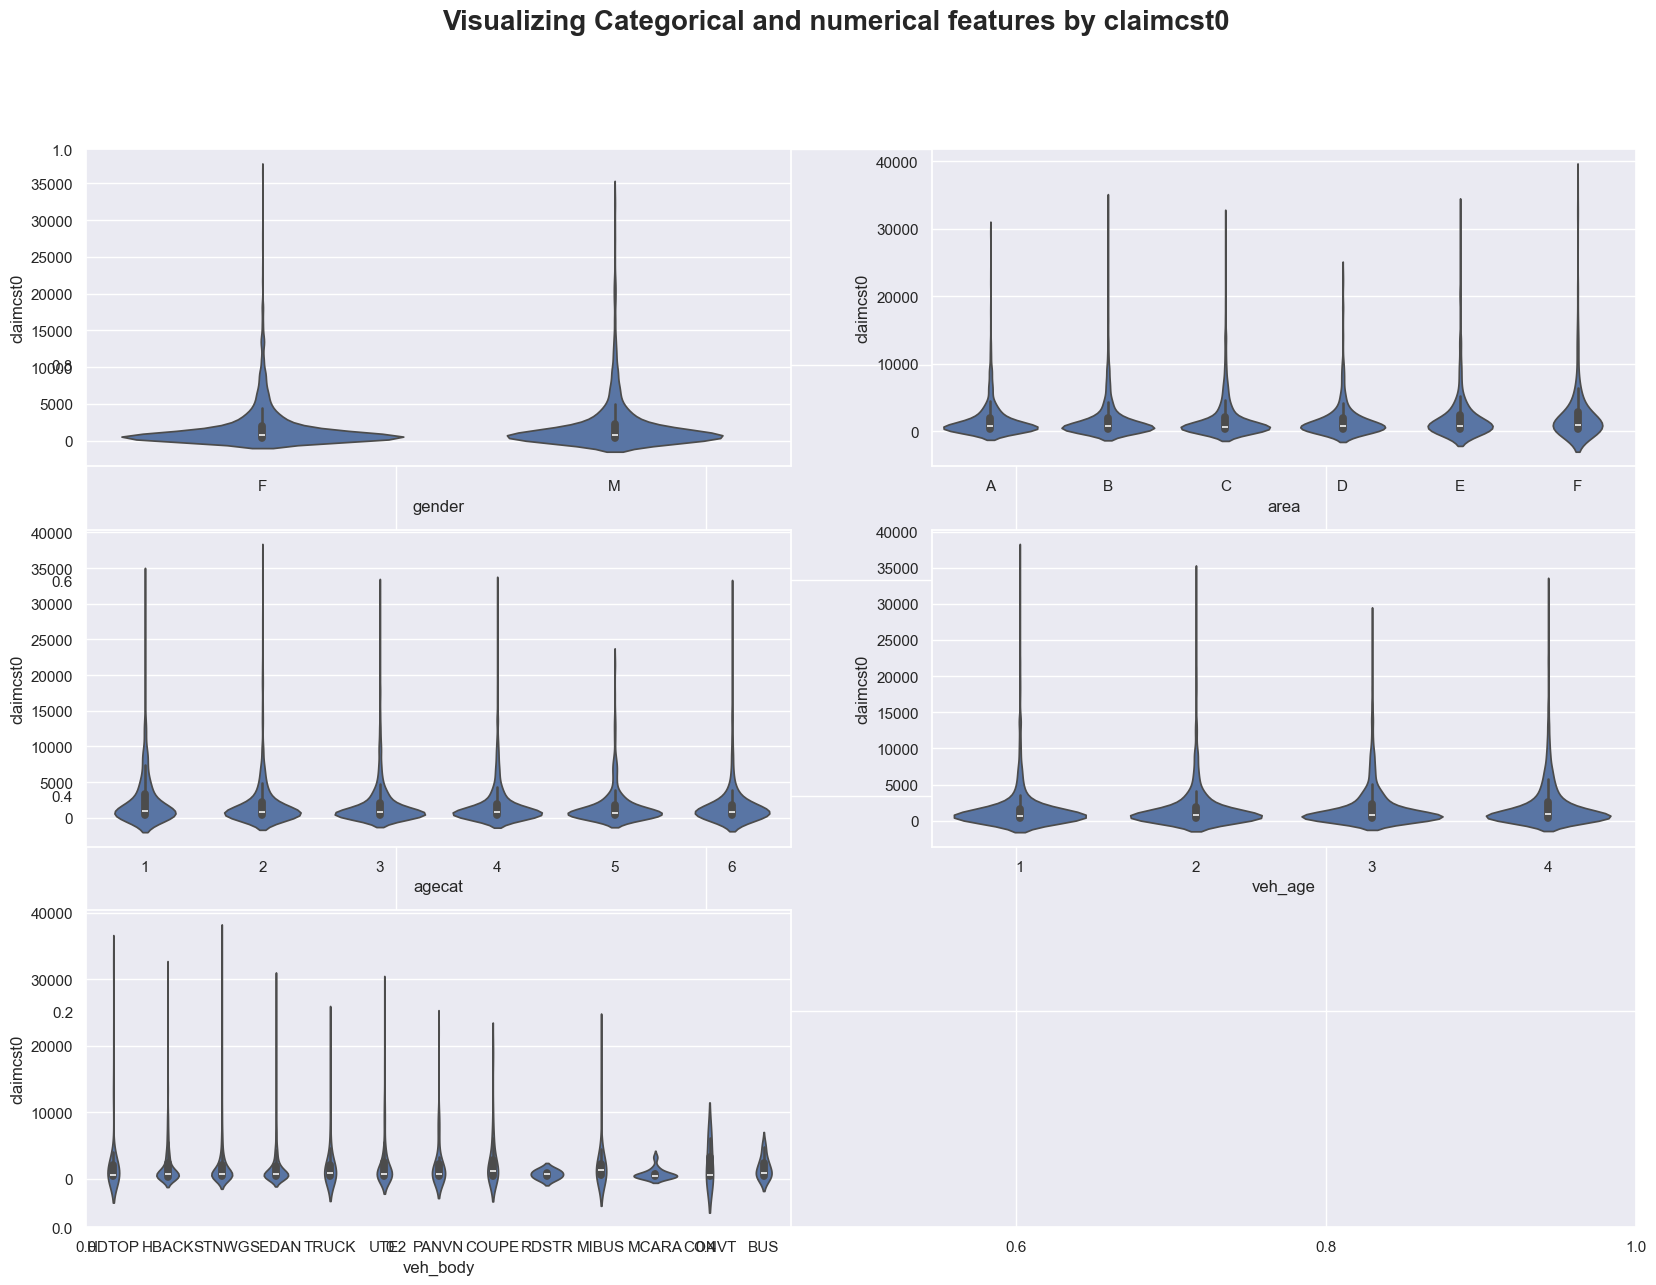

In [81]:
plt.subplots(figsize=(20,14))
plt.suptitle(f"Visualizing Categorical and numerical features by claimcst0",fontsize=20,fontweight="bold")
plt.subplot(321)
sns.violinplot(x="gender",y="claimcst0",data=df)
plt.subplot(322)
sns.violinplot(x="area",y="claimcst0",data=df)
plt.subplot(323)
sns.violinplot(x="agecat",y="claimcst0",data=df)
plt.subplot(324)
sns.violinplot(x="veh_age",y="claimcst0",data=df)
plt.subplot(325)
sns.violinplot(x="veh_body",y="claimcst0",data=df)

plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresbytargetGraphs/plot_features_by_claimcst0.png',dpi=500);

---

In [82]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

*Define x and y*

In [83]:
x=df.drop("claimcst0",axis=1)
y=df["claimcst0"]

In [84]:
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method="yeo-johnson")
transform_features=['veh_value']
df[transform_features]=pt.fit_transform(x[transform_features])

In [85]:
sc=StandardScaler()
preprocessor=ColumnTransformer([
    ("StandardScaler",sc,x.columns)
]
)

In [86]:
x=preprocessor.fit_transform(x)

In [87]:
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.2,random_state=42)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (3692, 7) and Y = (3692,) : 
Test data shape of X = (923, 7) and Y = (923,) : 


---

*Define models :*

In [88]:
models = {
                "RandomForestRegressor": RandomForestRegressor(),
                "DecisionTreeRegressor": DecisionTreeRegressor(),
                "XGBRFRegressor": XGBRFRegressor(),
                "GradientBoostingRegressor":GradientBoostingRegressor(),
                "AdaBoostRegressor": AdaBoostRegressor(),
                "KNeighborsRegressor":KNeighborsRegressor()              
}

*Create cross validation evaluation_fucntion*

In [89]:
def evaluation_preds_list(y_true,predicted):
    RMSE=root_mean_squared_error(y_true,predicted)
    r2score=r2_score(y_true,predicted)
    metrics_dict={
       "RMSE": round(RMSE,3),
       "r2score": round(r2score,3)
    }
   
    return metrics_dict

In [90]:
def evaluation_preds(y_true,predicted):
    RMSE=root_mean_squared_error(y_true,predicted)
    return RMSE

In [91]:
def evalua_models(x_train,y_train,models):
    #x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20,random_state=42)
    models_list=[]
    RMSE_list=[]
    for i in  range(len(list(models))):
        model=list(models.values())[i]
        model.fit(x_train,y_train)

        train_predicted=model.predict(x_train)
        test_predicted=model.predict(x_test)      
        
        test_predicted_RMSE=evaluation_preds(y_test,test_predicted)
       
        RMSE_list.append(test_predicted_RMSE)

        #print(list(models.keys())[i])
        
        models_list.append(list(models.keys())[i])
        
        #print( test_predicted_RMSE)
        #print("===========================")

    report=pd.DataFrame(list(zip(models_list,RMSE_list)),columns=["model","RMSE"]).sort_values(by="RMSE",ascending=True) 
    return report
  

In [92]:
base_models=evalua_models(x_train,y_train,models)
base_models

,model,RMSE
3,GradientBoostingRegressor,3278.476251
2,XGBRFRegressor,3321.982695
0,RandomForestRegressor,3457.540131
5,KNeighborsRegressor,3609.827925
4,AdaBoostRegressor,4778.646751
1,DecisionTreeRegressor,5002.964163


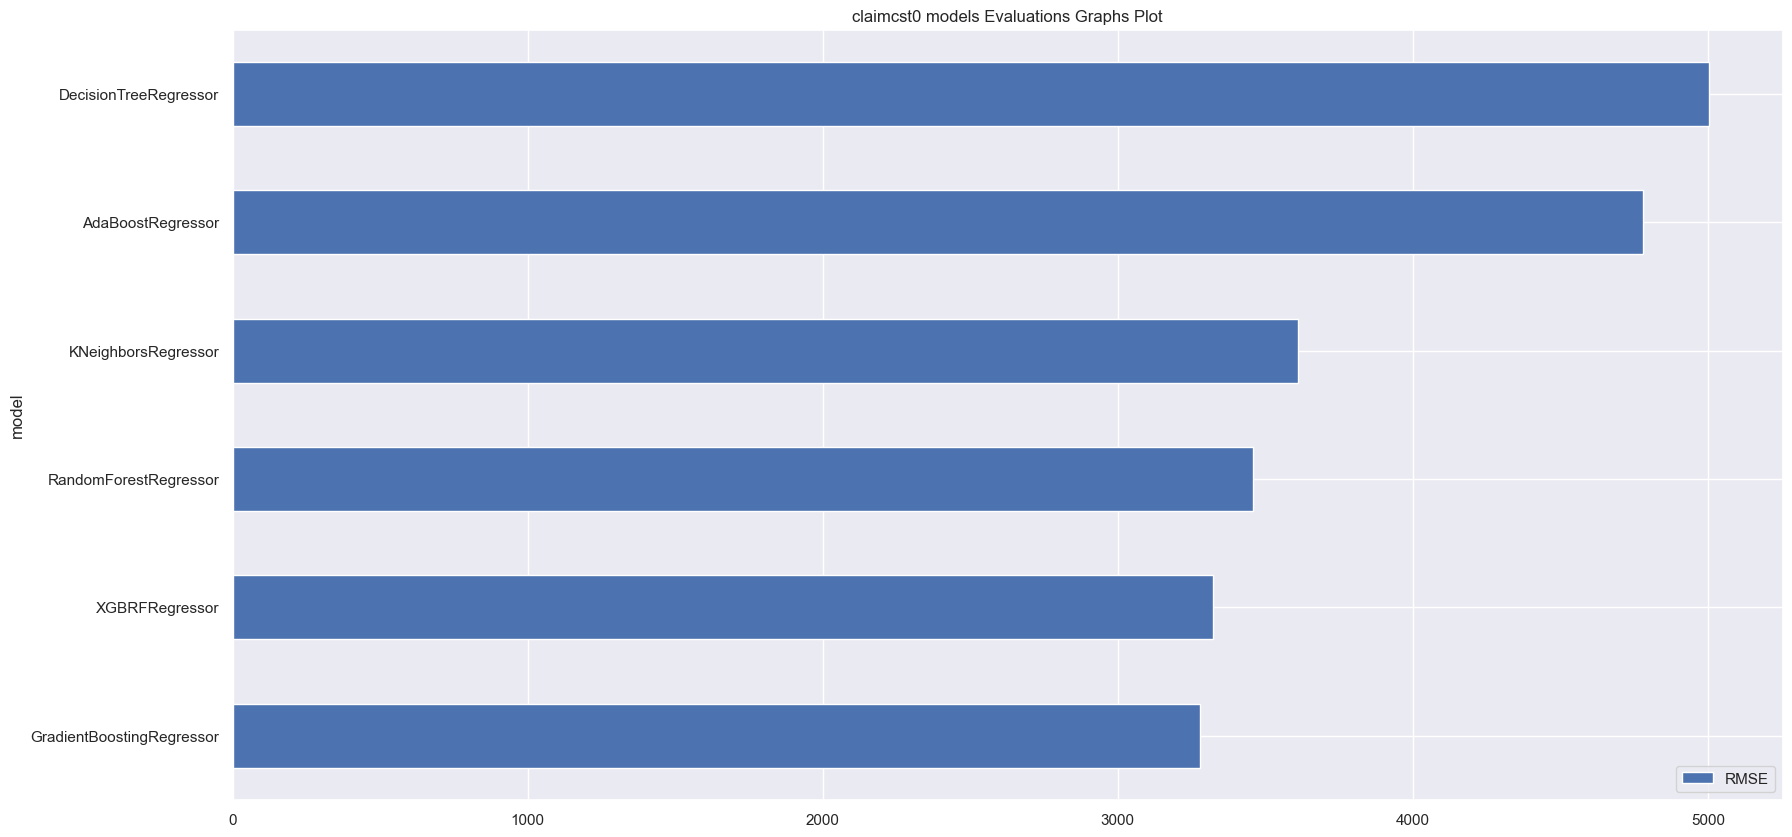

In [93]:
base_models.set_index("model").plot(kind="barh",figsize=(20,10),title="claimcst0 models Evaluations Graphs Plot");
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/modelsEvaluationsGraphs/claimcst0_EvaluationsGraph.png',dpi=500);

In [94]:
np.random.seed(42)
clf=GradientBoostingRegressor()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)

In [95]:
clf.feature_names=list(df.drop("claimcst0",axis=1).columns)
importance=pd.concat([pd.DataFrame(clf.feature_names,columns=["feature_names"]),
           pd.DataFrame(clf.feature_importances_,columns=["feature_importances"])],axis=1)
importance

,feature_names,feature_importances
0,veh_value,0.257590
1,exposure,0.516643
2,veh_body,0.035201
3,veh_age,0.058749
4,gender,0.026943
5,area,0.060214
6,agecat,0.044660


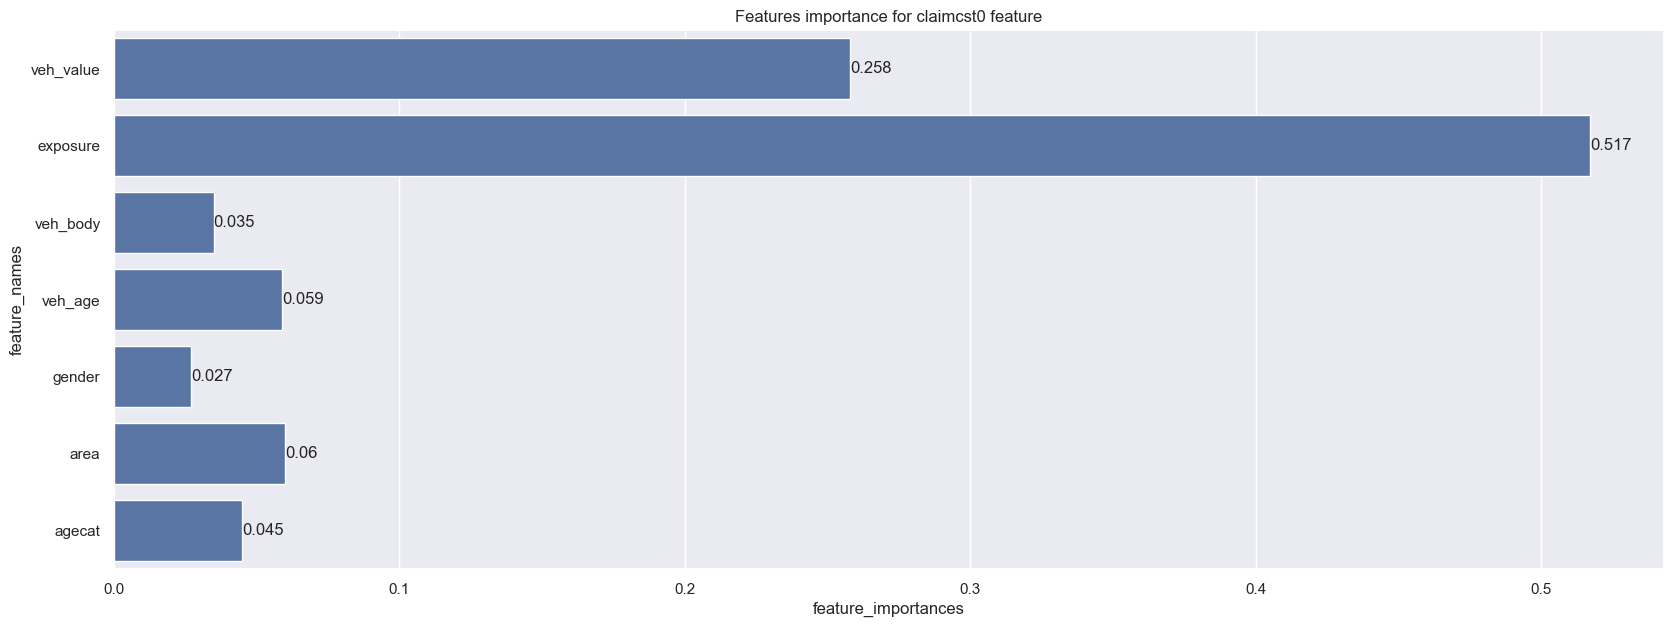

In [96]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for claimcst0 feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresImportanceGraphs/claimcst0_featureImportanc.png',dpi=500);

In [97]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestModels/claimcst0_prediction_model.pkl","wb") as f:
    pickle.dump(clf,f)

---